<a href="https://colab.research.google.com/github/20KMJ/ESAA7/blob/main/1031.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHAPTER 03 | 평가

> **머신러닝**
> - 데이터 가공/변환
> - 모델 학습/예측
> - **평가(Evaluation)**

성능 평가 지표(Evaluation Metric)는 일반적으로 모델이 분류냐 회귀냐에 따라 여러 종류로 나뉜다.

> **분류**의 성능평가 지표
> - 정확도(Accuracy)
> - 오차행렬(Confusion Matrix)
> - 정밀도(Precision)
> - 재현율(Recall)
> - F1 스코어
> - ROC AUC

분류는 결정 클래스 값 종류의 유형에 따라 긍정/부정과 같은 2개의 결괏값만을 가지는 **이진 분류**와 여러 개의 결정 클래스 값을 가지는 **멀티 분류**로 나뉠 수 있다.

# 01.정확도(Accuracy)

정확도는 실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표로, 직관적으로 모델 예측 성능을 나타낸다.
- 정확도(Accuracy) = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수

이진 분류의 경우 데이터의 구성에 따라 ML 모델의 성능을 왜곡할 수 있기 때문에 정확도 수치 하나만 가지고 성능을 평가하지 않는다.
정확도 지표가 어떻게 ML 모델의 성능을 왜곡하는지 예제로 살펴보자.

In [ ]:
# 사이킷런의 BaseEstimator 클래스를 상속받아 아무런 학습을 하지 않고,
# 성별에 따라 생존자를 예측하는 단순한 Classifier 생성
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # fit() 메서드는 아무것도 학습하지 않음.
    def fit(self, X, y=None):
        pass
    # predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함.
    def predict(self, X):
        pred = np.zeros( (X.shape[0], 1))
        for i in range (X.shape[0]) :
            if X['Sex'].iloc[i] ==1:
                pred[i] = 0
            else :
                pred[i] = 1
        
        return pred

In [ ]:
# 데이터 전처리 함수

from sklearn import preprocessing

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace = True)
    df['Embarked'].fillna('N', inplace = True)
    df['Fare'].fillna(0, inplace = True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출 (최종 함수)
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [ ]:
# 예측
# MyDummyClassifer 이용하기
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
titanic_df = pd.read_csv('C:/Temp/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test=train_test_split(X_titanic_df, y_titanic_df,
                                                  test_size=0.2, random_state=0)

# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는: 0.7877


이렇게 단순한 알고리즘으로 예측을 하더라도 데이터의 구성에 따라 정확도 결과는 약 78.77%로 꽤 높은 수치가 나올 수 있기에 정확도를 평가 지표로 사용할 때는 매우 신중해야 한다.

정확도는 불균형한(imbalanced) 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 정확한 평가 지표가 아니다. 유명한 MNIST 데이터 세트를 변환해 불균형한 데이터 세트로 만든 뒤에 정확도 지표 적용 시 어떤 문제가 발생할 수 있는지 살펴보자.

In [ ]:
# 불균형한 데이터 세트와 Dummy Classifer 생성
from sklearn import datasets

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 변환
    def predict(self, X):
        return np.zeros( (len(X), 1), dtype=bool)
    
# 사이킷런의 내장 데이터 세트인 load_digits()를 이용해서 MNIST 데이터 로딩
digits = datasets.load_digits()

# digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환.
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split( digits.data, y, random_state=11)

In [ ]:
# 불균형한 레이블 데이터 분포도 확인.
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정학도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


> 이처럼 정확도 평가 지표는 불균형한 레이블 데이터 세트에서는 성능 수치로 사용돼서는 안된다.

정확도가 가지는 분류 평가 지표로서 이러한 한계점을 극복하기 위해 여러 가지 분류 지표와 함께 적용해야 한다. 먼저 True/False, Positive/Negative의 4분면으로 구성되는 오차 행렬(Confusion Matrix)에 대해 살펴보자.

# 02.오차 행렬

오차행렬(confusion matrix, 혼동행렬)은 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고(confused) 있는지도 함께 보여주는 지표로, 이진 분류에서 성능 지표로 잘 활용된다. 즉, 이진 분류의 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 나타내는 지표이다.

- TN은 예측값을 Negative 값 0으로 예측했고 실제 값 역시 Negative 값
- FP는 예측값을 Positive 값 1로 예측했는데 실제 값은 Negative 값 0
- FN은 예측값을 Negative 값 0로 예측했는데 실제 값은 Positive 값 1
- TP는 예측값을 Positive 값 1로 예측했는데 실제 값 역시 Positive 값 1

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

> TN:405, FP:0  
> FN:45, TP:0

정확도  
= 예측 결과와 실제 값이 동일한 건수/전체 데이터 수  
= (TN + TP)/(TN + FP + FN + TP)

> 정확도는 분류(Classification) 모델의 성능을 측정할 수 있는 한 가지 요소일 뿐이다. 불균형한 데이터 세트에서 정확도만으로는 모델 신뢰도가 떨어질 수 있다. 다음으로 뷸균형한 데이터 세트에서 정확도보다 더 선호되는 평가 지표인 정밀도(Precision)와 재현율(Recall)에 대해 알아보자.

# 03.정밀도와 재현율

정밀도와 재현율은 Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표이다.
- 정밀도 = TP / (FP + TP)
- 재현율 = TP / (FN + TP)

**정밀도**는 예측을 Positive로 한 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율이다. Positive 예측 성능을 더욱 정밀하게 측정하기 위한 평가 지표로 양성 예측도라고 불린다.  
**재현율**은 실제 값이 Positive인 대상 중에 예측과 실제 값이 Positve로 일치한 데이터의 비율을 뜻한다. 민감도(Sensitivity) 또는 TPR(True Positive Rate)라고 불린다.

**재현율**이 상대적으로 더 중요한 지표인 경우는 실제 Positive 양성 데이터를 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우.  
ex) 암 판단 모델, 금융 사기 적발 모델(보험 사기)  
  
**정밀도**가 상대적으로 더 중요한 지표인 경우는 실제 Negative 음성인 데이터 예측을 Positive 양성으로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우.  
ex) 스팸메일 여부를 판단하는 모델

재현율과 정밀도 모두 TP를 높이는 데 동일하게 초점을 맞추지만, 재현율은 FN를 낮추는 데, 정밀도는 FP를 낮추는 데 초점을 맞춘다.

In [ ]:
# 타이타닉 예제 예측 성능 평가하기
# 정확도 + 오차 행렬 + 정밀도 + 재현율
# 정밀도 계산: precision_score()
# 재현율 계산: recall_score()
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# confusion matrix, accuracy, precison, recall 등의 평가를 한꺼번에 호출하는 함수
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [ ]:
# 생존자 예측 후 평가 수행
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
titanic_df = pd.read_csv('C:/Temp/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.20, random_state=11)

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


C:\Python\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


다음은 재현율 또는 정밀도를 좀 더 강화할 방법에 대해 알아보자.

## 정밀도/재현율 트레이드오프

정밀도 또는 재현율이 특별히 강조돼야 할 경우 분류의 결정 임곗값(Threshold)을 조정해 정밀도 또는 재현율의 수치를 높일 수 있다. 하지만 정밀도와 재현율은 상호 보완적인 평가 지표이기 때문에 어느 한 쪽을 높이면 다른 하나의 수치를 떨어지기 쉽다. 이를 정밀도/재현율의 트레이드오프(Trade-off)라고 부른다.

> `predict_proba()`
> - 개별 데이터별로 예측 확률을 반환하는 메서드
> - predict() 메서드와 유사하지만 단지 반환 결과가 예측 결과 클래스값이 아닌 **예측 확률 결과**  
> - 첫 번째 칼럼: 클래스 값 0에 대한 예측 확률  
> - 두 번째 칼럼: 클래스 값 1에 대한 예측 확률

In [ ]:
# predict_proba() vs predict()
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba()결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.46191331 0.53808669]
 [0.87867473 0.12132527]
 [0.8771619  0.1228381 ]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46191331 0.53808669 1.        ]
 [0.87867473 0.12132527 0.        ]
 [0.8771619  0.1228381  0.        ]]


사이킷런은 분류 결정 임곗값을 조절해 정밀도와 재현율의 성능 수치를 상호 보완적으로 조정할 수 있다. 이러한 로직을 직접 코드로 구현하면서 사이킷런의 정밀도/재현율 트레이드오프 방식을 이해해 보자.

In [ ]:
# Binarizer 클래스
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
     [2, 0, 0],
     [0, 1.1, 1.2]]

# X의 개별 원소들이 threshold 값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [ ]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값. 분류 결정 임곗값임.
custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 칼럼
# 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


In [ ]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤
custom_threshold = 0.4
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361


> 임곗값을 낮추니 재현율이 올라가고 정밀도가 떨어졌음.  
> Why? 분류 결정 임곗값은 Positive 예측값을 결정하는 확률이 기준이 되는데 확률이 0.5가 아닌 0.4부터 Positive로 예측을 너그럽게 하기 때문에 임곗값을 낮출수록 True 값이 많아지게 됨.  
> Positive 예측값이 많아지면 상대적으로 재현율 값이 높아짐. 양성 예측을 많이 하다 보니 실제 양성을 음성으로 예측하는 횟수가 상대적으로 줄어들기 때문.

임곗값을 0.4에서 0.6까지 0.05씩 증가시키며 평가 지표를 조사해보자.

In [ ]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장.
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)
        
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377


> 지금까지 임곗값 변화에 따른 평가 지표 값을 알아보는 코드를 살펴봤다. 사이킷런은 이와 유사한 precision_recall_curve() API를 제공한다.

입력 파라미터  
**y_true**: 실제 클래스값 배열 (배열 크기 = [데이터 건수])  
**probas_pred**: Positive 칼럼의 예측 확률 배열 (배열 크기 = [데이터 건수])
  
반환 값  
**정밀도**: 임곗값별 정밀도 값을 배열로 반환  
**재현율**: 임곗값별 재현율 값을 배열로 반환

In [ ]:
# precision_recall_curve()
# 타이타닉 예측 모델의 임곗값별 정밀도와 재현율을 구해 보자.

from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shpae:', thresholds.shape)

# 반환된 임곗값 로우가 143건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출.
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shpae: (143,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값:  [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임계값별 정밀도:  [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율:  [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


> 임곗값이 증가할수록 정밀도 값은 동시에 높아지나 재현율 값은 낮아짐을 알 수 있다.

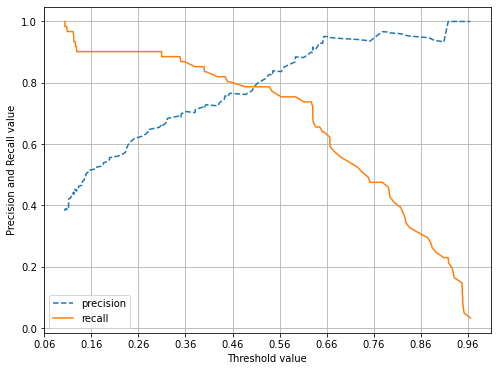

In [ ]:
# 정밀도와 재현율 곡선 시각화
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 X 축의 Scale을 0,1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # X축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

> 임곗값이 낮을수록 많은 수의 양성으로 인해 재현율 값이 극도로 높아지고 정밀도 값이 극도로 낮아진다.

## 정밀도와 재현율의 맹점

> **정밀도가 100%가 되는 방법**  
> - 확실한 기준이 되는 경우만 Positive로 예측하고 나머지는 모두 Negative로 예측  
  
> **재현율이 100%가 되는 방법**
> - 모든 환자를 Positive로 예측  

정밀도 또는 재현율 중 하나만 스코어가 좋고 다른 하나는 스코어가 나쁜 분류는 성능이 좋지 않은 분류이다. 정밀도와 재현율 수치가 적절하게 조합돼 분류의 종합적인 성능 평가에 사용될 수 있는 평가 지표가 필요하다.

# 04. F1 스코어 - `f1_score()`

F1 스코어(Score)는 정밀도와 재현율을 결합한 지표이다. 정밀도와 재현율이 어느 한쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가진다.
> F1 = 2 / (1/recall + 1/precision) = 2 * {(precision * recall) / (precision + recall)}

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


In [ ]:
# 임곗값 0.4 ~ 0.6별로 정확도, 정밀도, 재현율, F1 스코어 알아보기
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    # F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))
    
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값: 0.4
오차행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361, F1:0.7727
임곗값: 0.45
오차행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1:0.7840
임곗값: 0.5
오차행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1:0.7805
임곗값: 0.55
오차행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1:0.7931
임곗값: 0.6
오차행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1:0.8036


# 05. ROC 곡선과 AUC

ROC 곡선(Reciever Operation Characteristic Curve)
- 수신자 판단 곡선
- FPR(False Positive Rate)이 변할 때 TPR(True Positive Rate)이 어떻게 변하는지를 나타내는 곡선

> `roc_curve()`  
>
> 입력 파라미터  
> - **y_true**: 실제 클래스 값 array (array shape = [데이터 건수])  
> - **y_score**: predict_proba()의 반환 값 array에서 Positive 칼럼의 예측 확률이 보통 사용됨. array.shape = [n_sampels]  
>  
> 반환 값
> - **fpr**: fpr 값을 array로 반환  
> - **tpr**: tpr 값을 array로 반환  
> - **thresholds**: threshold 값 array

> - 민감도(TPR)은 실제값 Positive(양성)가 정확히 예측돼야 하는 수준을 나타낸다.(질병이 있는 사람은 질병이 있는 것응로 양성 판정)
> - 특이성(TNR)은 실제값 Negative(음성)가 정확히 예측돼야 하는 수준을 나타낸다.(질병이 없는 건강한 사람은 질병이 없는 것으로 음성 판정)

> TNR = TN / ( FP + TN )  
> FPR = FP / ( FP + TN ) = 1 - TNR = 1 - 특이성

ROC 곡선이 가운데직선에 가까울수록 성능이 떨어지는 것이며, 멀어질수록 성능이 뛰어난 것이다.

In [ ]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열 로우가 47건이므로 샘플로 10건만 추출하되, 임곗값을 5 Step으로 추출.
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 5 Step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index 10개: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임곗값:  [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임곗값별 FPR:  [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임곗값별 TPR:  [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


> 임곗값이 1에 가까운 값에서 점점 작아지면서 FPR이 점점 커진다. 그리고 FPR이 조금씩 커질 때 TPR은 가파르게 커진다.

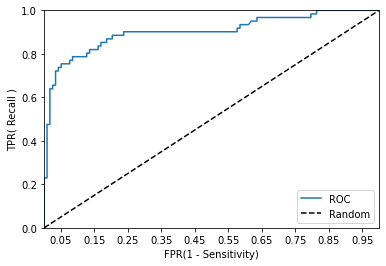

In [ ]:
# FPR의 변화에 따른 TPR의 변화를 ROC 곡선으로 시각화
def roc_curve_plot(y_test, pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환받음.
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # ROC 곡선을 그래프 곡선으로 그림.
    plt.plot(fprs, tprs, label='ROC')
    # 가운데 대각선 직선을 그림
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel('FPR(1 - Sensitivity)'); plt.ylabel('TPR( Recall )')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:, 1])    

#일반적으로 ROC 곡선 자체는 FPR과 TPR의 변화 값을 보는 데 이용하며 분류의 성능 지표로 사용되는 것은 ROC 곡선 면적에 기반한 AUC 값으로 결정한다. AUC(Area Under Curve) 값은 ROC 곡선 밑의 면적을 구한 것으로서 일반적으로 1에 가까울수록 좋은 수치이다. AUC 수치가 커지려면 FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있느냐가 관건이다. 가운데 직선에서 멀어지고 왼쪽 상단 모서리 쪽으로 가파르게 곡선이 이동할수록 직사각형에 가까운 곡선이 되어 면적이 1에 가까워지는 좋은 ROC AUC 성능 수치를 얻게 된다. 가운데 대각선 직선은 랜덤 수준의(동전 던지기 수준) 이진 분류 AUC 값으로 0.5이다. 따라서 보통의 분류는 0.5 이상의 AUC 값을 가진다.

In [ ]:
# y_target?

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

print(confusion_matrix(y_target, preds))
print("정확도:", np.round(accuracy_score(y_target, preds), 4))
print("정밀도:", np.round(precision_score(y_target, preds), 4))
print("재현율:", np.round(recall_score(y_target, preds), 4))

NameError: name 'y_target' is not defined

In [ ]:
# get_clf_eval()
# 정확도, 정밀도, 재현율, F1 스코어, ROC AUC 값 모두 출력

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, \
        F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))